In [1]:
#region
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


#endregion

In [2]:
import torch

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cpu


In [3]:
import pandas as pd
import numpy as np
data = pd.read_csv(r"/kaggle/input/output2/Original_output_File.csv")
data

,Quiz,Solution
0,0832954170018000590950008620700009000000700203...,6832954174218673597953418625721349868465791233...
1,1007540320002060070048390500010780000405903100...,1697548323582169472748396515314782967465923189...
2,7000508398000250409300782002798004000004970266...,7126548398659237419341782652798614533584971266...
3,0000930078030000290590824039003502016001007081...,2145936878637415297596824139783542616351247481...
4,6507300901986000070370002560003456020000010742...,6527348911986524374371982569713456823852619742...
...,...,...
49995,0896000576200001000408102060107098239020800000...,1896243576279351845438172964167598239724835613...
49996,7413090080050800402300000701000260276570481903...,7413592689657823412386149751895364276572481933...
49997,2004639101040080000800057034200070060008064919...,2574639181347986256892157434219573863758264919...
49998,9082000000024609706248000507000193800000025003...,9382571461524639786748912537256193844693825173...


In [23]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import random

class SudokuDataset(Dataset):
    def __init__(self, dataframe, subset="train", augment=False):
        self.dataframe = dataframe
        self.subset = subset
        self.augment = augment and subset == "train"

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        puzzle = self.dataframe.iloc[idx, 0]  # Accessing the 'Quiz' column
        solution = self.dataframe.iloc[idx, 1]  # Accessing the 'Solution' column

        puzzle_np = np.array([int(p) for p in puzzle], dtype=np.float32).reshape(9, 9)
        solution_np = np.array([max(int(s) - 1, 0) for s in solution], dtype=np.int64).reshape(9, 9)

        if self.augment:
            puzzle_np, solution_np = self.augment_data(puzzle_np, solution_np)

        puzzle_tensor = torch.tensor(puzzle_np, dtype=torch.float32).unsqueeze(0) / 9 - 0.5
        solution_tensor = torch.tensor(solution_np, dtype=torch.int64).reshape(81)

        if self.subset == 'train':
            return puzzle_tensor, solution_tensor
        return puzzle_tensor

    def augment_data(self, puzzle, solution):
        # Randomly choose an augmentation method
        methods = [self.rotate_puzzle, self.reflect_puzzle]
        augment_method = random.choice(methods)
        return augment_method(puzzle), augment_method(solution)

    @staticmethod
    def rotate_puzzle(puzzle):
        # Rotate the puzzle by 90 degrees
        return np.rot90(puzzle)

    @staticmethod
    def reflect_puzzle(puzzle):
        # Reflect the puzzle horizontally or vertically
        if random.choice([True, False]):
            return np.flipud(puzzle)  # Up-down reflection
        else:
            return np.fliplr(puzzle)  # Left-right reflection


In [24]:
train_idx = int(len(data) * 0.75)
train_data = SudokuDataset(data.iloc[:train_idx], subset="train")
train_loader = DataLoader(train_data, batch_size=640, shuffle=True)

val_data = SudokuDataset(data.iloc[train_idx:], subset="train")
val_loader = DataLoader(val_data, batch_size=640, shuffle=False)


In [25]:
import torch.nn as nn
import torch.nn.functional as F

class SudokuSolver(nn.Module):
    def __init__(self):
        super(SudokuSolver, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=1)
        self.fc1 = nn.Linear(128 * 9 * 9, 81 * 9)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.dropout2(x)
        x = self.fc1(x)
        x = self.dropout3(x)
        return x.view(-1, 9)  # Reshaped to match [batch_size * 81, 9]

model = SudokuSolver()

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

def train_model(model, train_loader, val_loader, epochs, device):
    model.to(device)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Lists to store metrics
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for puzzles, solutions in train_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)
            optimizer.zero_grad()
            outputs = model(puzzles)
            loss = criterion(outputs, solutions.view(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += calculate_accuracy(outputs, solutions.view(-1)) * solutions.size(0)
            total_train += solutions.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / total_train

        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for puzzles, solutions in val_loader:
                puzzles, solutions = puzzles.to(device), solutions.to(device)
                outputs = model(puzzles)
                val_loss += criterion(outputs, solutions.view(-1)).item()

                val_correct += calculate_accuracy(outputs, solutions.view(-1)) * solutions.size(0)
                total_val += solutions.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / total_val

        # Append metrics to lists
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}: '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Return metrics for plotting
    return train_losses, val_losses, train_accuracies, val_accuracies


Epoch 1: Train Loss: 2.1768, Train Accuracy: 0.1456, Validation Loss: 2.0220, Validation Accuracy: 0.1990
Epoch 2: Train Loss: 2.0254, Train Accuracy: 0.2031, Validation Loss: 1.9381, Validation Accuracy: 0.2389
Epoch 3: Train Loss: 1.9652, Train Accuracy: 0.2378, Validation Loss: 1.8567, Validation Accuracy: 0.2875
Epoch 4: Train Loss: 1.8831, Train Accuracy: 0.2783, Validation Loss: 1.7201, Validation Accuracy: 0.3531
Epoch 5: Train Loss: 1.7473, Train Accuracy: 0.3355, Validation Loss: 1.5284, Validation Accuracy: 0.4470
Epoch 6: Train Loss: 1.6258, Train Accuracy: 0.3845, Validation Loss: 1.3923, Validation Accuracy: 0.5085
Epoch 7: Train Loss: 1.5379, Train Accuracy: 0.4215, Validation Loss: 1.2942, Validation Accuracy: 0.5539
Epoch 8: Train Loss: 1.4657, Train Accuracy: 0.4516, Validation Loss: 1.2053, Validation Accuracy: 0.5878
Epoch 9: Train Loss: 1.3989, Train Accuracy: 0.4786, Validation Loss: 1.1322, Validation Accuracy: 0.6197
Epoch 10: Train Loss: 1.3377, Train Accuracy: 

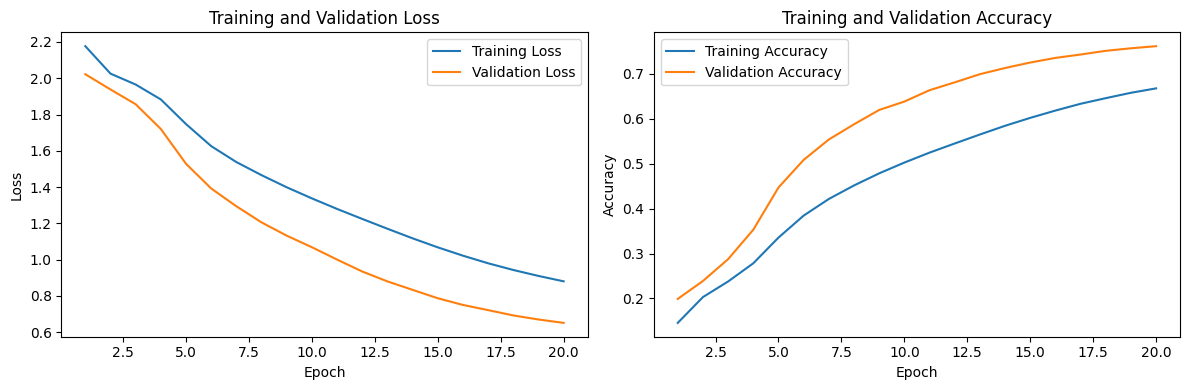

In [27]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Train the model and get metrics
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, 20, device)

# Plot the metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


In [28]:
import pandas as pd
test=pd.read_csv(r"/kaggle/input/test-image-10000/Train_Output_Test_submission_10000.csv")
test

,ID,Concatenated Values
0,0,9027008637614000250800000706070950009106000542...
1,1,0708010200207300001060920040800754800520080038...
2,2,0009001650806000306012437008070950230307046009...
3,3,1580096070000760027264183000157040000040800510...
4,4,0020500096038002059700008361080005032060350800...
...,...,...
9995,9995,0001050300407062100009405607510943060202507040...
9996,9996,1058000404001300056030509170006005315060030092...
9997,9997,0000278000703000900487500362800000040524009783...
9998,9998,0020950000391800001050020980017200803275009169...


In [29]:
def preprocess_puzzle(puzzle_str):
    """
    Preprocess the input Sudoku puzzle string into a format suitable for the model.
    """
    puzzle_tensor = torch.tensor([int(p) for p in puzzle_str], dtype=torch.float32).reshape(1, 1, 9, 9) / 9 - 0.5
    return puzzle_tensor.to(device)

def predict_test_set(model, test_df):
    """
    Predict solutions for all puzzles in the test DataFrame.
    """
    model.eval()
    predictions = []

    for _, row in test_df.iterrows():
        puzzle_str = row['Concatenated Values']  # Corrected column name
        with torch.no_grad():
            puzzle_tensor = preprocess_puzzle(puzzle_str)
            output = model(puzzle_tensor)
            solution = output.argmax(dim=1).view(9, 9) + 1  # Convert predictions to 1-based indexing
            predictions.append(solution.cpu().numpy())

    return predictions

In [30]:
# predict on the entire test set
predicted_solutions = predict_test_set(model, test)

indexes = []
labels= []
#for i,j in enumerate(predicted_solutions_df["predicted_solution"]):
for i,j in enumerate(predicted_solutions):
    preds = j.reshape(9,9)
    for row in range(0,9):
        for col in range(0,9):
            index = str(i)+"_"+str(row)+str(col)
            indexes.append(index)
            labels.append(preds[row,col])

Test_Predictions =  {"id":indexes , "values":labels}
Test_Predictions = pd.DataFrame(Test_Predictions)
Test_Predictions

Test_Predictions.to_csv("/kaggle/working/Test_Predictions.csv", index=False)